<a href="https://colab.research.google.com/github/hemanthsunny/knowledge_graphs_0.1/blob/master/first_kg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [0]:
from spacy.matcher import Matcher
from spacy.tokens import Span

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [0]:
#sentences = pd.read_csv('https://github.com/hemanthsunny/knowledge_graphs_0.1/wiki_sentences_v2.csv')

# Reference: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

In [8]:
from google.colab import files
uploaded = files.upload()

Saving wiki_sentences_v2.csv to wiki_sentences_v2.csv


In [9]:
uploaded

{'wiki_sentences_v2.csv': b'sentence\n"confused and frustrated, connie decides to leave on her own."\n"later, a woman\xe2\x80\x99s scream is heard in the distance."\nchristian is then paralyzed by an elder.\nthe temple is set on fire.\n"outside, the cult wails with him."\nit\'s a parable of a woman\'s religious awakening\xe2\x80\x94\n"c. mackenzie, and craig vincent joined the cast."\n"later, craig di francia and action bronson were revealed to have joined the cast."\nsebastian maniscalco and paul ben-victor were later revealed as being part of the cast.\nwe just tried to make the film.\nwe went through all these tests and things  \nm global was also circling to bid for the film\'s international sales rights.\ncanadian musician robbie robertson supervised the soundtrack.\nit features both original and existing music tracks.\nit is the worst reviewed film in the franchise.\nbut she injures quicksilver and accidentally kills mystique before flying away.\nmilitary forces tasked with her a

In [10]:
import io

sentences = pd.read_csv(io.BytesIO(uploaded['wiki_sentences_v2.csv']))
sentences

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


In [11]:
sentences.shape

(4318, 1)

In [14]:
sentences['sentence'].sample(5)

1035                                                            financially, much larger capital was required to operate out of a major city.
3203                                                      molecular beam epitaxy is a particularly sophisticated form of thermal evaporation.
3429                                                                                        he taught me the chapin method : 'nuts and bolts!
2012                                                                                                       the building was finished in 1982.
1942    barbara wilson, tom o’connor, noel starblanket, roy daniels, morris isaac, willie dunn, and mike kanentakeron mitchell were on canada
Name: sentence, dtype: object

In [15]:
doc = nlp('the drawdown process is governed by astm standard d823')
for tok in doc:
  print(tok.text, '---', tok.dep_)

the --- det
drawdown --- compound
process --- nsubjpass
is --- auxpass
governed --- ROOT
by --- agent
astm --- compound
standard --- pobj
d823 --- punct


In [0]:
def get_entities(sent):
  ent1 = ""
  ent2 = ""

  prev_token_dep = '' #dependency tag of previous token
  prev_token_text = ''

  prefix = ''
  modifier = ''

  for tok in nlp(sent):
    if tok.dep_ != 'punct':
      
      if tok.dep_ == 'compound':
        prefix = tok.text
        if prev_token_dep == 'compound':
          prefix = prev_token_text + " " + tok.text

      if tok.dep_.endswith('mod') == True:
        modifier = tok.text
        if prev_token_dep == 'compound':
          modifier = prev_token_text + " " + tok.text

      if tok.dep_.find('subj') == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modfier = ""
        prev_token_text = ""
        prev_token_dep = ""

      if tok.dep_.find('obj') == True:
        ent2 = modifier + " " + prefix + " " + tok.text
      
      prev_token_dep = tok.dep_
      prev_token_text = tok.text
  return [ent1.strip(), ent2.strip()]

In [30]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [31]:
doc2 = nlp('the film had 200 patents')
for tok in doc2:
  print(tok.text, ". . .", tok.dep_)

the . . . det
film . . . nsubj
had . . . ROOT
200 . . . nummod
patents . . . dobj


In [0]:
entity_pairs = []

for i in tqdm(sentences['sentence']):
  entity_pairs.append(get_entities(i))

In [33]:
entity_pairs[10:20]

[['we', 'tests'],
 ['global', 'international sales rights'],
 ['robbie  robertson', 'robbie  soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'military  arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'sequel']]

In [0]:
def get_relation(sent):
  doc = nlp(sent)
  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'}, {'DEP':'prep', 'OP': "?"}, {'DEP':'agent', 'OP':"?"}, {'POS':'ADJ', 'OP':"?"}]
  
  matcher.add('matching_1', None, pattern)
  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [37]:
get_relation('John completed the task')
get_relation('the film had 200 patents')

'had'

In [0]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]

In [40]:
pd.Series(relations).value_counts()[:50]

is               368
was              283
released on       79
are               72
include           69
were              63
's                42
released          41
have              30
has               30
composed by       29
became            29
become            28
released in       28
considered        22
included          21
produced          19
called            19
had               19
be                19
used              18
been              18
stars             18
scheduled         17
made              16
directed by       15
hired             14
wrote             14
set               14
went              14
introduced in     13
written by        13
received          13
wanted            12
sold              12
won               11
cast as           11
gave              10
began             10
began in          10
features          10
produced by       10
includes          10
shot in            9
used in            9
gives              9
reported           9
directed     

In [0]:
# Build a knowledge graph

source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]

In [0]:
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
kg_df

In [0]:
# Creating a directed graph
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

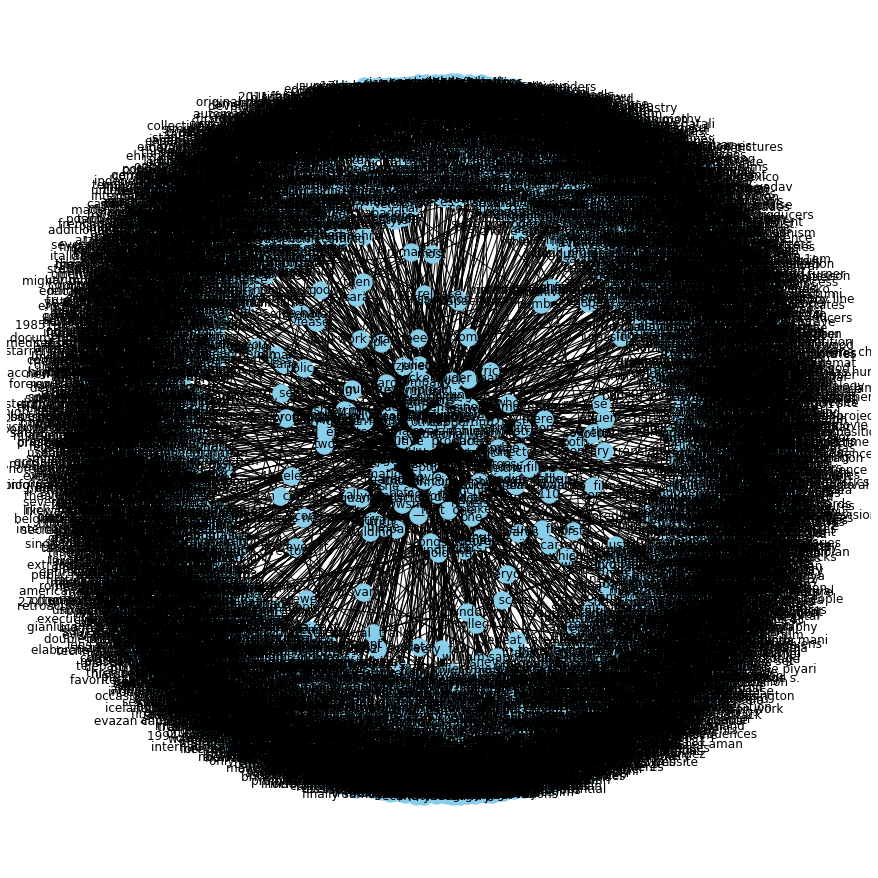

In [48]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)

plt.show()